# Constants

In [1]:
DATASET_PATH = '../data/breast_cancer.csv'

# Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Boosting algorithm
# import lightgbm as lgb

# Add path to local project source code
import sys
sys.path.append('../src')

# Import custom Repeated Nested CV class
from RepeatedNestedCV import RepeatedNestedCV

# Analysis

## Algorithms & Params

In [3]:
# We use lambda **kwargs so that Optuna can pass hyperparameters into the constructor.
estimators = {
    "LR": lambda **kwargs: LogisticRegression(random_state=42, **kwargs),
    "GNB": GaussianNB,
    # "LDA": LinearDiscriminantAnalysis,
    # "SVC": lambda **kwargs: SVC(probability=True, **kwargs), # Without the "probability" fixed value, AUC will be none for SVM
    # "RF": RandomForestClassifier,
    # "LGBM": lambda **kwargs: lgb.LGBMClassifier(random_state=42, **kwargs),
}

param_spaces = {
    "LR": lambda trial: {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'solver': 'saga', # Fixed for Elastic Net Regularization
        'penalty': 'elasticnet', # Fixed for Elastic Net Regularization
        'max_iter': 1000
    },
    "GNB": lambda trial: {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    },
    # "LDA": lambda trial: {
    #     'solver': trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    # },
    # "SVC": lambda trial: {
    #     'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
    #     'gamma': trial.suggest_float('gamma', 1e-4, 1e0, log=True),
    # },
    # "RF": lambda trial: {
    #     'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    #     'max_depth': trial.suggest_int('max_depth', 3, 20),
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    # },
    # "LGBM": lambda trial: {
    #     'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'num_leaves': trial.suggest_int('num_leaves', 20, 100),
    #     'max_depth': trial.suggest_int('max_depth', 3, 12),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 5, 30)
    # }
}

## Prepare Dataset

In [4]:
df = pd.read_csv(DATASET_PATH)
df.drop('id', axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].replace({'M': '1', 'B': '0'}).astype(int)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,14.68,20.13,94.74,684.5,0.09867,0.07200,0.07395,0.05259,0.1586,...,19.07,30.88,123.40,1138.0,0.1464,0.1871,0.29140,0.16090,0.3029,0.08216
1,0,11.50,18.45,73.28,407.4,0.09345,0.05991,0.02638,0.02069,0.1834,...,12.97,22.46,83.12,508.9,0.1183,0.1049,0.08105,0.06544,0.2740,NaN
2,1,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.23220,0.11190,0.2809,0.06287
3,1,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,0.08744,0.1943,...,22.66,30.93,145.30,1603.0,0.1390,0.3463,0.39120,0.17080,0.3007,0.08314
4,0,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,...,13.74,19.93,88.81,585.4,0.1483,NaN,0.22410,0.10560,0.3380,0.09584


## nCV

In [5]:
# Extract X and y from dataframe
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values

In [6]:
rncv = RepeatedNestedCV(
    X=X,
    y=y,
    estimators=estimators,
    param_spaces=param_spaces,
)

rncv.run()

[I 2025-04-25 19:27:15,655] A new study created in memory with name: no-name-d11c555f-4612-4d4b-b2f0-385a409c06cc
[I 2025-04-25 19:27:15,686] Trial 0 finished with value: 0.8702859020958894 and parameters: {'C': 0.017670169402947963, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.8702859020958894.
[I 2025-04-25 19:27:15,729] Trial 1 finished with value: 0.9353124087918996 and parameters: {'C': 2.4658329458549115, 'l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.9353124087918996.
[I 2025-04-25 19:27:15,741] Trial 2 finished with value: 0.41353986515276836 and parameters: {'C': 0.0008632008168602552, 'l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.9353124087918996.
[I 2025-04-25 19:27:15,751] Trial 3 finished with value: 0.0 and parameters: {'C': 0.00022310108018679258, 'l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.9353124087918996.
[I 2025-04-25 19:27:15,769] Trial 4 finished with value: 0.952996632996633 and parameters: {'C


>>> Repetition 1/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:27:15,855] Trial 9 finished with value: 0.923611111111111 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 19:27:15,882] Trial 10 finished with value: 0.9426083501820971 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 19:27:15,903] Trial 11 finished with value: 0.9529251700680272 and parameters: {'C': 0.3595818378592206, 'l1_ratio': 0.7206532007461377}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 19:27:15,923] Trial 12 finished with value: 0.9529251700680272 and parameters: {'C': 0.31009679134694135, 'l1_ratio': 0.7331983444045209}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 19:27:15,970] Trial 13 finished with value: 0.9389957365189563 and parameters: {'C': 39.61364848460911, 'l1_ratio': 0.39245289210263246}. Best is trial 4 with value: 0.952996632996633.
[I 2

Tuning: GNB


[I 2025-04-25 19:27:17,056] Trial 19 finished with value: 0.9043411178904552 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.9043411178904552.
[I 2025-04-25 19:27:17,068] Trial 20 finished with value: 0.9043411178904552 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.9043411178904552.
[I 2025-04-25 19:27:17,080] Trial 21 finished with value: 0.9043411178904552 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.9043411178904552.
[I 2025-04-25 19:27:17,092] Trial 22 finished with value: 0.9043411178904552 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.9043411178904552.
[I 2025-04-25 19:27:17,105] Trial 23 finished with value: 0.9043411178904552 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.9043411178904552.
[I 2025-04-25 19:27:17,120] Trial 24 finished with value: 0.9043411178904552 and par


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:27:17,622] Trial 11 finished with value: 0.9566640232619613 and parameters: {'C': 0.3595818378592206, 'l1_ratio': 0.7206532007461377}. Best is trial 10 with value: 0.9638167700265172.
[I 2025-04-25 19:27:17,644] Trial 12 finished with value: 0.9636730549036066 and parameters: {'C': 0.48453986090750284, 'l1_ratio': 0.7331983444045209}. Best is trial 10 with value: 0.9638167700265172.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:17,703] Trial 13 finished with value: 0.9549216874426039 and parameters: {'C': 43.713458476718706, 'l1_ratio': 0.39245289210263246}. Best is trial 10 with value: 0.9638167700265172.
[I 2025-04-25 19:27:17,731] Trial 14 finished with value: 0.9513725490196078 and parameters: {'C': 1.5743950427221742, 'l1_ratio': 0.01317673246334039}. Best is trial 10 with value: 0.963816770026

Tuning: GNB


[I 2025-04-25 19:27:19,000] Trial 20 finished with value: 0.8764959170323999 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8764959170323999.
[I 2025-04-25 19:27:19,011] Trial 21 finished with value: 0.8764959170323999 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8764959170323999.
[I 2025-04-25 19:27:19,022] Trial 22 finished with value: 0.8764959170323999 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.8764959170323999.
[I 2025-04-25 19:27:19,033] Trial 23 finished with value: 0.8764959170323999 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.8764959170323999.
[I 2025-04-25 19:27:19,044] Trial 24 finished with value: 0.8764959170323999 and parameters: {'var_smoothing': 1.827049756885987e-08}. Best is trial 0 with value: 0.8764959170323999.
[I 2025-04-25 19:27:19,054] Trial 25 finished with value: 0.8764959170323999 and par


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:27:19,533] Trial 11 finished with value: 0.950732396518478 and parameters: {'C': 1.45278349655044, 'l1_ratio': 0.591383763117016}. Best is trial 4 with value: 0.9536282000205413.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:19,576] Trial 12 finished with value: 0.94170840053193 and parameters: {'C': 71.33774409326645, 'l1_ratio': 0.7137227598653364}. Best is trial 4 with value: 0.9536282000205413.
[I 2025-04-25 19:27:19,598] Trial 13 finished with value: 0.9464869281045751 and parameters: {'C': 0.512215485964238, 'l1_ratio': 0.39245289210263246}. Best is trial 4 with value: 0.9536282000205413.
[I 2025-04-25 19:27:19,636] Trial 14 finished with value: 0.9445777534012828 and parameters: {'C': 5.032429817293674, 'l1_ratio': 0.01317673246334039}. Best is trial 4 with value: 0.9536282000205413.
[I 2025-

Tuning: GNB


[I 2025-04-25 19:27:20,654] Trial 21 finished with value: 0.8840395012688954 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8840395012688954.
[I 2025-04-25 19:27:20,664] Trial 22 finished with value: 0.8840395012688954 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.8840395012688954.
[I 2025-04-25 19:27:20,674] Trial 23 finished with value: 0.8840395012688954 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.8840395012688954.
[I 2025-04-25 19:27:20,684] Trial 24 finished with value: 0.8840395012688954 and parameters: {'var_smoothing': 1.827049756885987e-08}. Best is trial 0 with value: 0.8840395012688954.
[I 2025-04-25 19:27:20,694] Trial 25 finished with value: 0.8840395012688954 and parameters: {'var_smoothing': 1.004033882355603e-09}. Best is trial 0 with value: 0.8840395012688954.
[I 2025-04-25 19:27:20,704] Trial 26 finished with value: 0.8840395012688954 and para


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:27:21,153] Trial 11 finished with value: 0.9539118579666838 and parameters: {'C': 1.45278349655044, 'l1_ratio': 0.591383763117016}. Best is trial 4 with value: 0.9566074813867133.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:21,202] Trial 12 finished with value: 0.9434106069612311 and parameters: {'C': 71.33774409326645, 'l1_ratio': 0.7137227598653364}. Best is trial 4 with value: 0.9566074813867133.
[I 2025-04-25 19:27:21,223] Trial 13 finished with value: 0.9532443238259544 and parameters: {'C': 0.512215485964238, 'l1_ratio': 0.39245289210263246}. Best is trial 4 with value: 0.9566074813867133.
[I 2025-04-25 19:27:21,258] Trial 14 finished with value: 0.9535914375751301 and parameters: {'C': 5.032429817293674, 'l1_ratio': 0.01317673246334039}. Best is trial 4 with value: 0.9566074813867133.
[I 20

Tuning: GNB


[I 2025-04-25 19:27:22,526] Trial 21 finished with value: 0.9036025448396584 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.9036025448396584.
[I 2025-04-25 19:27:22,536] Trial 22 finished with value: 0.9036025448396584 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.9036025448396584.
[I 2025-04-25 19:27:22,547] Trial 23 finished with value: 0.9036025448396584 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.9036025448396584.
[I 2025-04-25 19:27:22,557] Trial 24 finished with value: 0.9036025448396584 and parameters: {'var_smoothing': 1.827049756885987e-08}. Best is trial 0 with value: 0.9036025448396584.
[I 2025-04-25 19:27:22,568] Trial 25 finished with value: 0.9036025448396584 and parameters: {'var_smoothing': 1.004033882355603e-09}. Best is trial 0 with value: 0.9036025448396584.
[I 2025-04-25 19:27:22,578] Trial 26 finished with value: 0.9036025448396584 and para


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:27:23,037] Trial 11 finished with value: 0.966192537621109 and parameters: {'C': 0.3595818378592206, 'l1_ratio': 0.7206532007461377}. Best is trial 10 with value: 0.9698316498316498.
[I 2025-04-25 19:27:23,059] Trial 12 finished with value: 0.9663973063973064 and parameters: {'C': 0.48453986090750284, 'l1_ratio': 0.7331983444045209}. Best is trial 10 with value: 0.9698316498316498.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:23,111] Trial 13 finished with value: 0.9509436380531257 and parameters: {'C': 43.713458476718706, 'l1_ratio': 0.39245289210263246}. Best is trial 10 with value: 0.9698316498316498.
[I 2025-04-25 19:27:23,143] Trial 14 finished with value: 0.9634983498349835 and parameters: {'C': 1.5743950427221742, 'l1_ratio': 0.01317673246334039}. Best is trial 10 with value: 0.9698316498316

Tuning: GNB


[I 2025-04-25 19:27:24,325] Trial 21 finished with value: 0.9007511163211666 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.9007511163211666.
[I 2025-04-25 19:27:24,335] Trial 22 finished with value: 0.9007511163211666 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.9007511163211666.
[I 2025-04-25 19:27:24,345] Trial 23 finished with value: 0.9007511163211666 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.9007511163211666.
[I 2025-04-25 19:27:24,355] Trial 24 finished with value: 0.9007511163211666 and parameters: {'var_smoothing': 1.827049756885987e-08}. Best is trial 0 with value: 0.9007511163211666.
[I 2025-04-25 19:27:24,365] Trial 25 finished with value: 0.9007511163211666 and parameters: {'var_smoothing': 1.004033882355603e-09}. Best is trial 0 with value: 0.9007511163211666.
[I 2025-04-25 19:27:24,375] Trial 26 finished with value: 0.9007511163211666 and para


>>> Repetition 2/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:27:24,825] Trial 11 finished with value: 0.9636886018698957 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 11 with value: 0.9636886018698957.
[I 2025-04-25 19:27:24,850] Trial 12 finished with value: 0.9570879418038891 and parameters: {'C': 0.830738758661789, 'l1_ratio': 0.41351924297227105}. Best is trial 11 with value: 0.9636886018698957.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:24,911] Trial 13 finished with value: 0.9570723948376 and parameters: {'C': 91.63501828440783, 'l1_ratio': 0.6034723224446881}. Best is trial 11 with value: 0.9636886018698957.
[I 2025-04-25 19:27:24,934] Trial 14 finished with value: 0.9570879418038891 and parameters: {'C': 0.7755729133778976, 'l1_ratio': 0.4003980547423486}. Best is trial 11 with value: 0.9636886018698957.
/

Tuning: GNB


[I 2025-04-25 19:27:26,290] Trial 21 finished with value: 0.8924262942027866 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8924262942027866.
[I 2025-04-25 19:27:26,300] Trial 22 finished with value: 0.8924262942027866 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8924262942027866.
[I 2025-04-25 19:27:26,310] Trial 23 finished with value: 0.8924262942027866 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8924262942027866.
[I 2025-04-25 19:27:26,321] Trial 24 finished with value: 0.8924262942027866 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.8924262942027866.
[I 2025-04-25 19:27:26,331] Trial 25 finished with value: 0.8924262942027866 and parameters: {'var_smoothing': 3.7733711230976027e-10}. Best is trial 0 with value: 0.8924262942027866.
[I 2025-04-25 19:27:26,341] Trial 26 finished with value: 0.8924262942027866 and 


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:27:26,797] Trial 11 finished with value: 0.9502911467617349 and parameters: {'C': 76.98123919677761, 'l1_ratio': 0.014268393733033763}. Best is trial 7 with value: 0.9502911467617349.
[I 2025-04-25 19:27:26,837] Trial 12 finished with value: 0.9502911467617349 and parameters: {'C': 57.50579077018148, 'l1_ratio': 0.2207284664975004}. Best is trial 7 with value: 0.9502911467617349.
[I 2025-04-25 19:27:26,867] Trial 13 finished with value: 0.9436844044548511 and parameters: {'C': 3.634395348645825, 'l1_ratio': 0.3374537693902746}. Best is trial 7 with value: 0.9502911467617349.
[I 2025-04-25 19:27:26,901] Trial 14 finished with value: 0.9436844044548511 and parameters: {'C': 6.851954426010942, 'l1_ratio': 0.13005767776725113}. Best is trial 7 with value: 0.9502911467617349.
[I 2025-04-25 19:27:26,919] Trial 15 finished with value: 0.9422643097643096 and parameters: {'C': 0.2867931296646739, 'l1_ratio': 0.41829305748018075}. Best is trial 7 with value: 0.9502911467617349.


Tuning: GNB


[I 2025-04-25 19:27:28,247] Trial 21 finished with value: 0.8723232323232324 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8723232323232324.
[I 2025-04-25 19:27:28,257] Trial 22 finished with value: 0.8723232323232324 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8723232323232324.
[I 2025-04-25 19:27:28,268] Trial 23 finished with value: 0.8723232323232324 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8723232323232324.
[I 2025-04-25 19:27:28,278] Trial 24 finished with value: 0.8723232323232324 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.8723232323232324.
[I 2025-04-25 19:27:28,288] Trial 25 finished with value: 0.8723232323232324 and parameters: {'var_smoothing': 3.7733711230976027e-10}. Best is trial 0 with value: 0.8723232323232324.
[I 2025-04-25 19:27:28,298] Trial 26 finished with value: 0.8723232323232324 and 


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:27:28,758] Trial 11 finished with value: 0.9536633663366336 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 3 with value: 0.9536633663366336.
[I 2025-04-25 19:27:28,782] Trial 12 finished with value: 0.9536633663366336 and parameters: {'C': 0.7735992959694693, 'l1_ratio': 0.5051535230029698}. Best is trial 3 with value: 0.9536633663366336.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:28,846] Trial 13 finished with value: 0.9442148098304975 and parameters: {'C': 91.63812627651475, 'l1_ratio': 0.4329730998746223}. Best is trial 3 with value: 0.9536633663366336.
[I 

Tuning: GNB


[I 2025-04-25 19:27:29,976] Trial 21 finished with value: 0.9137726257779467 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.9137726257779467.
[I 2025-04-25 19:27:29,986] Trial 22 finished with value: 0.9137726257779467 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.9137726257779467.
[I 2025-04-25 19:27:29,996] Trial 23 finished with value: 0.9137726257779467 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.9137726257779467.
[I 2025-04-25 19:27:30,006] Trial 24 finished with value: 0.9137726257779467 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.9137726257779467.
[I 2025-04-25 19:27:30,016] Trial 25 finished with value: 0.9137726257779467 and parameters: {'var_smoothing': 3.7733711230976027e-10}. Best is trial 0 with value: 0.9137726257779467.
[I 2025-04-25 19:27:30,026] Trial 26 finished with value: 0.9137726257779467 and 


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:27:30,481] Trial 12 finished with value: 0.94718954248366 and parameters: {'C': 0.7735992959694693, 'l1_ratio': 0.5051535230029698}. Best is trial 3 with value: 0.94718954248366.
[I 2025-04-25 19:27:30,520] Trial 13 finished with value: 0.9442071197411003 and parameters: {'C': 91.63812627651475, 'l1_ratio': 0.4329730998746223}. Best is trial 3 with value: 0.94718954248366.
[I 2025-04-25 19:27:30,539] Trial 14 finished with value: 0.94718954248366 and parameters: {'C': 0.6229329456279659, 'l1_ratio': 0.650380546553906}. Best is trial 3 with value: 0.94718954248366.
[I 2025-04-25 19:27:30,573] Trial 15 finished with value: 0.9442071197411003 and parameters: {'C': 7.9180459971801485, 'l1_ratio': 0.9907102787441292}. Best is trial 3 with value: 0.94718954248366.
[I 2025-04-25 19:27:30,588] Trial 16 finished with value: 0.9463945578231292 and parameters: {'C': 0.1560391952737388, 'l1_ratio': 0.3585726701269202}. Best is trial 3 with value: 0.94718954248366.
[I 2025-04-25 19

Tuning: GNB


[I 2025-04-25 19:27:31,552] Trial 20 finished with value: 0.8862877624167947 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8862877624167947.
[I 2025-04-25 19:27:31,562] Trial 21 finished with value: 0.8862877624167947 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8862877624167947.
[I 2025-04-25 19:27:31,572] Trial 22 finished with value: 0.8862877624167947 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8862877624167947.
[I 2025-04-25 19:27:31,583] Trial 23 finished with value: 0.8862877624167947 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8862877624167947.
[I 2025-04-25 19:27:31,593] Trial 24 finished with value: 0.8862877624167947 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.8862877624167947.
[I 2025-04-25 19:27:31,603] Trial 25 finished with value: 0.8862877624167947 and 


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:27:32,070] Trial 12 finished with value: 0.9520214777106712 and parameters: {'C': 0.7735992959694693, 'l1_ratio': 0.5051535230029698}. Best is trial 12 with value: 0.9520214777106712.
[I 2025-04-25 19:27:32,091] Trial 13 finished with value: 0.945225976915589 and parameters: {'C': 0.3999298103313026, 'l1_ratio': 0.5878913637393888}. Best is trial 12 with value: 0.9520214777106712.
[I 2025-04-25 19:27:32,138] Trial 14 finished with value: 0.9355135411343894 and parameters: {'C': 20.87181466756909, 'l1_ratio': 0.4003980547423486}. Best is trial 12 with value: 0.9520214777106712.
[I 2025-04-25 19:27:32,159] Trial 15 finished with value: 0.9459218030646602 and parameters: {'C': 0.1766105164971272, 'l1_ratio': 0.9907102787441292}. Best is trial 12 with value: 0.9520214777106712.
[I 2025-04-25 19:27:32,197] Trial 16 finished with value: 0.9355135411343894 and parameters: {'C': 4.556015658061084, 'l1_ratio': 0.6399062404616851}. Best is trial 12 with value: 0.9520214777106712

Tuning: GNB


[I 2025-04-25 19:27:33,257] Trial 19 finished with value: 0.8794444070257366 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8794444070257366.
[I 2025-04-25 19:27:33,267] Trial 20 finished with value: 0.8794444070257366 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8794444070257366.
[I 2025-04-25 19:27:33,279] Trial 21 finished with value: 0.8794444070257366 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8794444070257366.
[I 2025-04-25 19:27:33,289] Trial 22 finished with value: 0.8794444070257366 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8794444070257366.
[I 2025-04-25 19:27:33,299] Trial 23 finished with value: 0.8794444070257366 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8794444070257366.
[I 2025-04-25 19:27:33,309] Trial 24 finished with value: 0.8794444070257366 and 


>>> Repetition 3/10

Outer Fold 1/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:33,779] Trial 8 finished with value: 0.9401824065901736 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 0 with value: 0.9401824065901736.
[I 2025-04-25 19:27:33,796] Trial 9 finished with value: 0.9368904733610616 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 0 with value: 0.9401824065901736.
[I 2025-04-25 19:27:33,809] Trial 10 finished with value: 0.14430131272236535 and parameters: {'C': 0.00023910639516549903, 'l1_ratio': 0.011064280912793642}. Best is trial 0 with value: 0.9401824065901736.
[I 2025-04-25 19:27:33,855] Trial 11 finished with value: 0.9401824065901736 and parameters: {'C': 74.91001688210295, 'l1_ratio': 0.2515976600338624}. Best is trial 0 with value: 0.940182406590173

Tuning: GNB


[I 2025-04-25 19:27:34,795] Trial 21 finished with value: 0.8795053655707016 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8795053655707016.
[I 2025-04-25 19:27:34,805] Trial 22 finished with value: 0.8795053655707016 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8795053655707016.
[I 2025-04-25 19:27:34,815] Trial 23 finished with value: 0.8795053655707016 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8795053655707016.
[I 2025-04-25 19:27:34,825] Trial 24 finished with value: 0.8795053655707016 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8795053655707016.
[I 2025-04-25 19:27:34,836] Trial 25 finished with value: 0.8795053655707016 and parameters: {'var_smoothing': 8.831488716955872e-10}. Best is trial 0 with value: 0.8795053655707016.
[I 2025-04-25 19:27:34,846] Trial 26 finished with value: 0.8795053655707016 and pa


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:27:35,315] Trial 9 finished with value: 0.9532443238259544 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 4 with value: 0.9559983498349834.
[I 2025-04-25 19:27:35,327] Trial 10 finished with value: 0.0 and parameters: {'C': 0.00023910639516549903, 'l1_ratio': 0.6989316586775665}. Best is trial 4 with value: 0.9559983498349834.
[I 2025-04-25 19:27:35,349] Trial 11 finished with value: 0.9501349894773282 and parameters: {'C': 0.9886535476203318, 'l1_ratio': 0.006388564248959394}. Best is trial 4 with value: 0.9559983498349834.
[I 2025-04-25 19:27:35,385] Trial 12 finished with value: 0.9537116778846499 and parameters: {'C': 6.383128471645861, 'l1_ratio': 0.7676948139644678}. Best is trial 4 with value: 0.9559983498349834.
[I 2025-04-25 19:27:35,402] Trial 13 finished with value: 0.959844983891961 and parameters: {'C': 0.22675817936841244, 'l1_ratio': 0.5996194000698587}. Best is trial 13 with value: 0.959844983891961.
[I 2025-04

Tuning: GNB


[I 2025-04-25 19:27:36,376] Trial 21 finished with value: 0.8938973397736284 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8938973397736284.
[I 2025-04-25 19:27:36,386] Trial 22 finished with value: 0.8938973397736284 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8938973397736284.
[I 2025-04-25 19:27:36,397] Trial 23 finished with value: 0.8938973397736284 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8938973397736284.
[I 2025-04-25 19:27:36,407] Trial 24 finished with value: 0.8938973397736284 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8938973397736284.
[I 2025-04-25 19:27:36,417] Trial 25 finished with value: 0.8938973397736284 and parameters: {'var_smoothing': 8.831488716955872e-10}. Best is trial 0 with value: 0.8938973397736284.
[I 2025-04-25 19:27:36,427] Trial 26 finished with value: 0.8938973397736284 and pa


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:27:36,876] Trial 9 finished with value: 0.9601229119675722 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 0 with value: 0.9607824288996575.
[I 2025-04-25 19:27:36,889] Trial 10 finished with value: 0.18846842812360054 and parameters: {'C': 0.00023910639516549903, 'l1_ratio': 0.011064280912793642}. Best is trial 0 with value: 0.9607824288996575.
[I 2025-04-25 19:27:36,918] Trial 11 finished with value: 0.9607824288996575 and parameters: {'C': 2.5441477328580206, 'l1_ratio': 0.2658929849695544}. Best is trial 0 with value: 0.9607824288996575.
[I 2025-04-25 19:27:36,951] Trial 12 finished with value: 0.9607824288996575 and parameters: {'C': 4.286142533292899, 'l1_ratio': 0.2795395688194267}. Best is trial 0 with value: 0.9607824288996575.
[I 2025-04-25 19:27:36,983] Trial 13 finished with value: 0.9607824288996575 and parameters: {'C': 4.101155571127802, 'l1_ratio': 0.050860154064355845}. Best is trial 0 with value: 0.96078242889

Tuning: GNB


[I 2025-04-25 19:27:37,979] Trial 21 finished with value: 0.8737639385651167 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8737639385651167.
[I 2025-04-25 19:27:37,991] Trial 22 finished with value: 0.8737639385651167 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8737639385651167.
[I 2025-04-25 19:27:38,002] Trial 23 finished with value: 0.8737639385651167 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8737639385651167.
[I 2025-04-25 19:27:38,013] Trial 24 finished with value: 0.8737639385651167 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8737639385651167.
[I 2025-04-25 19:27:38,025] Trial 25 finished with value: 0.8737639385651167 and parameters: {'var_smoothing': 8.831488716955872e-10}. Best is trial 0 with value: 0.8737639385651167.
[I 2025-04-25 19:27:38,036] Trial 26 finished with value: 0.8737639385651167 and pa


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:27:38,509] Trial 8 finished with value: 0.9463067592386892 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 0 with value: 0.9499535787912525.
[I 2025-04-25 19:27:38,529] Trial 9 finished with value: 0.9499623687858981 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 9 with value: 0.9499623687858981.
[I 2025-04-25 19:27:38,551] Trial 10 finished with value: 0.9499623687858981 and parameters: {'C': 0.6982496104183762, 'l1_ratio': 0.013508968700207902}. Best is trial 9 with value: 0.9499623687858981.
[I 2025-04-25 19:27:38,572] Trial 11 finished with value: 0.9531919434440442 and parameters: {'C': 0.6110800927633833, 'l1_ratio': 0.006388564248959394}. Best is trial 11 with value: 0.9531919434440442.
[I 2025-04-25 19:27:38,594] Trial 12 finished with value: 0.9567562998796878 and parameters: {'C': 0.5588209479960894, 'l1_ratio': 0.2561604906209697}. Best is trial 12 with value: 0.95675629987968

Tuning: GNB


[I 2025-04-25 19:27:39,571] Trial 20 finished with value: 0.8832613448514904 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8832613448514904.
[I 2025-04-25 19:27:39,581] Trial 21 finished with value: 0.8832613448514904 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8832613448514904.
[I 2025-04-25 19:27:39,591] Trial 22 finished with value: 0.8832613448514904 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8832613448514904.
[I 2025-04-25 19:27:39,601] Trial 23 finished with value: 0.8832613448514904 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8832613448514904.
[I 2025-04-25 19:27:39,611] Trial 24 finished with value: 0.8832613448514904 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8832613448514904.
[I 2025-04-25 19:27:39,621] Trial 25 finished with value: 0.8832613448514904 and pa


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:27:40,120] Trial 8 finished with value: 0.9538556185715659 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 1 with value: 0.957011137011137.
[I 2025-04-25 19:27:40,141] Trial 9 finished with value: 0.9526229119675721 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 1 with value: 0.957011137011137.
[I 2025-04-25 19:27:40,152] Trial 10 finished with value: 0.0 and parameters: {'C': 0.00023910639516549903, 'l1_ratio': 0.3060587470782148}. Best is trial 1 with value: 0.957011137011137.
[I 2025-04-25 19:27:40,184] Trial 11 finished with value: 0.9538461538461539 and parameters: {'C': 2.5441477328580206, 'l1_ratio': 0.006388564248959394}. Best is trial 1 with value: 0.957011137011137.
[I 2025-04-25 19:27:40,222] Trial 12 finished with value: 0.9507438436151308 and parameters: {'C': 4.286142533292899, 'l1_ratio': 0.24700368487898627}. Best is trial 1 with value: 0.957011137011137.
[I 2025-04-25 19

Tuning: GNB


[I 2025-04-25 19:27:41,571] Trial 21 finished with value: 0.8836464795227682 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8836464795227682.
[I 2025-04-25 19:27:41,581] Trial 22 finished with value: 0.8836464795227682 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8836464795227682.
[I 2025-04-25 19:27:41,591] Trial 23 finished with value: 0.8836464795227682 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8836464795227682.
[I 2025-04-25 19:27:41,601] Trial 24 finished with value: 0.8836464795227682 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8836464795227682.
[I 2025-04-25 19:27:41,611] Trial 25 finished with value: 0.8836464795227682 and parameters: {'var_smoothing': 8.831488716955872e-10}. Best is trial 0 with value: 0.8836464795227682.
[I 2025-04-25 19:27:41,621] Trial 26 finished with value: 0.8836464795227682 and pa


>>> Repetition 4/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:27:42,086] Trial 8 finished with value: 0.9498949894989499 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9556027771933516.
[I 2025-04-25 19:27:42,098] Trial 9 finished with value: 0.9408479532163744 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9556027771933516.
[I 2025-04-25 19:27:42,127] Trial 10 finished with value: 0.9564289762309564 and parameters: {'C': 2.0686900349728425, 'l1_ratio': 0.9880559420712453}. Best is trial 10 with value: 0.9564289762309564.
[I 2025-04-25 19:27:42,150] Trial 11 finished with value: 0.9527871154462385 and parameters: {'C': 0.9337609520040442, 'l1_ratio': 0.991386873424817}. Best is trial 10 with value: 0.9564289762309564.
[I 2025-04-25 19:27:42,175] Trial 12 finished with value: 0.9527871154462385 and parameters: {'C': 1.312500904083652, 'l1_ratio': 0.9054810123643176}. Best is trial 10 with value: 0.9564289762309564.


Tuning: GNB


[I 2025-04-25 19:27:43,080] Trial 21 finished with value: 0.9017911494494705 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.9017911494494705.
[I 2025-04-25 19:27:43,090] Trial 22 finished with value: 0.9017911494494705 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.9017911494494705.
[I 2025-04-25 19:27:43,100] Trial 23 finished with value: 0.9017911494494705 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.9017911494494705.
[I 2025-04-25 19:27:43,110] Trial 24 finished with value: 0.9017911494494705 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.9017911494494705.
[I 2025-04-25 19:27:43,120] Trial 25 finished with value: 0.9017911494494705 and parameters: {'var_smoothing': 1.2419509279809219e-09}. Best is trial 0 with value: 0.9017911494494705.
[I 2025-04-25 19:27:43,130] Trial 26 finished with value: 0.9017911494494705 and para


Outer Fold 2/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:27:43,604] Trial 8 finished with value: 0.9469306930693069 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 0 with value: 0.9469306930693069.
[I 2025-04-25 19:27:43,616] Trial 9 finished with value: 0.9109913568676454 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 0 with value: 0.9469306930693069.
[I 2025-04-25 19:27:43,650] Trial 10 finished with value: 0.9469306930693069 and parameters: {'C': 2.0686900349728425, 'l1_ratio': 0.9880559420712453}. Best is trial 0 with value: 0.9469306930693069.
[I 2025-04-25 19:27:43,689] Trial 11 finished with value: 0.9469306930693069 and parameters: {'C': 4.763057392778167, 'l1_ratio': 0.8060129200944958}. Best is trial 0 with value: 0.9469306930693069.
[I 

Tuning: GNB


[I 2025-04-25 19:27:45,108] Trial 21 finished with value: 0.8957369963800503 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8957369963800503.
[I 2025-04-25 19:27:45,119] Trial 22 finished with value: 0.8957369963800503 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8957369963800503.
[I 2025-04-25 19:27:45,129] Trial 23 finished with value: 0.8957369963800503 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8957369963800503.
[I 2025-04-25 19:27:45,140] Trial 24 finished with value: 0.8957369963800503 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.8957369963800503.
[I 2025-04-25 19:27:45,150] Trial 25 finished with value: 0.8957369963800503 and parameters: {'var_smoothing': 1.2419509279809219e-09}. Best is trial 0 with value: 0.8957369963800503.
[I 2025-04-25 19:27:45,160] Trial 26 finished with value: 0.8957369963800503 and para


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:27:45,619] Trial 7 finished with value: 0.9508154698965042 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9508154698965042.
[I 2025-04-25 19:27:45,673] Trial 8 finished with value: 0.9411664152840623 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9508154698965042.
[I 2025-04-25 19:27:45,684] Trial 9 finished with value: 0.9451473922902495 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9508154698965042.
[I 2025-04-25 19:27:45,723] Trial 10 finished with value: 0.9447034447034448 and parameters: {'C': 2.0686900349728425, 'l1_ratio': 0.9880559420712453}. Best is trial 7 with value: 0.9508154698965042.
[I 2025-04-25 19:27:45,742] Trial 11 finished with value: 0.9570827632925104 and parameters: {'C': 0.3992239197487261, 'l1_ratio': 0.2766996661947905}. Best is trial 11 with value: 0.9570827632925104.
[

Tuning: GNB


[I 2025-04-25 19:27:46,873] Trial 20 finished with value: 0.8886130718334991 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8886130718334991.
[I 2025-04-25 19:27:46,883] Trial 21 finished with value: 0.8886130718334991 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8886130718334991.
[I 2025-04-25 19:27:46,893] Trial 22 finished with value: 0.8886130718334991 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8886130718334991.
[I 2025-04-25 19:27:46,903] Trial 23 finished with value: 0.8886130718334991 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8886130718334991.
[I 2025-04-25 19:27:46,913] Trial 24 finished with value: 0.8886130718334991 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.8886130718334991.
[I 2025-04-25 19:27:46,923] Trial 25 finished with value: 0.8886130718334991 and param


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:27:47,407] Trial 8 finished with value: 0.9698832913118628 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 0 with value: 0.9698832913118628.
[I 2025-04-25 19:27:47,419] Trial 9 finished with value: 0.9375459926411773 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 0 with value: 0.9698832913118628.
[I 2025-04-25 19:27:47,451] Trial 10 finished with value: 0.963265306122449 and parameters: {'C': 2.0686900349728425, 'l1_ratio': 0.9880559420712453}. Best is trial 0 with value: 0.9698832913118628.
[I 2025-04-25 19:27:47,497] Trial 11 finished with value: 0.9663788592360021 and parameters: {'C': 73.887772806438, 'l1_ratio': 0.44199585901205024}. Best is trial 0 with value: 0.9698832913118628.
[I 2025-04-25 19:27:47,535] Trial 12 finished with value: 0.9663788592360021 and parameters: {'C': 4.9499480956796855, 'l1_ratio': 0.8331296069778493}. Best is trial 0 with value: 0.9698832913118628.
[I 2

Tuning: GNB


[I 2025-04-25 19:27:49,071] Trial 20 finished with value: 0.8781288156288157 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8781288156288157.
[I 2025-04-25 19:27:49,082] Trial 21 finished with value: 0.8781288156288157 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8781288156288157.
[I 2025-04-25 19:27:49,093] Trial 22 finished with value: 0.8781288156288157 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8781288156288157.
[I 2025-04-25 19:27:49,103] Trial 23 finished with value: 0.8781288156288157 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8781288156288157.
[I 2025-04-25 19:27:49,113] Trial 24 finished with value: 0.8781288156288157 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.8781288156288157.
[I 2025-04-25 19:27:49,124] Trial 25 finished with value: 0.8781288156288157 and param


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:27:49,595] Trial 9 finished with value: 0.9374867091972355 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 0 with value: 0.960650453394854.
[I 2025-04-25 19:27:49,630] Trial 10 finished with value: 0.9575442604226158 and parameters: {'C': 2.0686900349728425, 'l1_ratio': 0.9880559420712453}. Best is trial 0 with value: 0.960650453394854.
[I 2025-04-25 19:27:49,666] Trial 11 finished with value: 0.960650453394854 and parameters: {'C': 4.763057392778167, 'l1_ratio': 0.8060129200944958}. Best is trial 0 with value: 0.960650453394854.
[I 2025-04-25 19:27:49,701] Trial 12 finished with value: 0.960650453394854 and parameters: {'C': 11.29254238936442, 'l1_ratio': 0.7079315550603795}. Best is trial 0 with value: 0.960650453394854.
[I 2025-04-25 19:27:49,739] Trial 13 finished with value: 0.960650453394854 and parameters: {'C': 14.900548252567134, 'l1_ratio': 0.867519273759902}. Best is trial 0 with value: 0.960650453394854.
[I 2025-04

Tuning: GNB


[I 2025-04-25 19:27:51,027] Trial 21 finished with value: 0.9018077295643177 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.9018077295643177.
[I 2025-04-25 19:27:51,037] Trial 22 finished with value: 0.9018077295643177 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.9018077295643177.
[I 2025-04-25 19:27:51,047] Trial 23 finished with value: 0.9018077295643177 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.9018077295643177.
[I 2025-04-25 19:27:51,058] Trial 24 finished with value: 0.9018077295643177 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.9018077295643177.
[I 2025-04-25 19:27:51,068] Trial 25 finished with value: 0.9018077295643177 and parameters: {'var_smoothing': 1.2419509279809219e-09}. Best is trial 0 with value: 0.9018077295643177.
[I 2025-04-25 19:27:51,079] Trial 26 finished with value: 0.9018077295643177 and para


>>> Repetition 5/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:27:51,529] Trial 9 finished with value: 0.8998719464144996 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 5 with value: 0.9524273303619021.
[I 2025-04-25 19:27:51,553] Trial 10 finished with value: 0.9573696145124716 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.054245160547296015}. Best is trial 10 with value: 0.9573696145124716.
[I 2025-04-25 19:27:51,574] Trial 11 finished with value: 0.9603610675039246 and parameters: {'C': 0.6730893408706707, 'l1_ratio': 0.00788018900310572}. Best is trial 11 with value: 0.9603610675039246.
[I 2025-04-25 19:27:51,596] Trial 12 finished with value: 0.9603610675039246 and parameters: {'C': 0.6483159529436975, 'l1_ratio': 0.012937960793218385}. Best is trial 11 with value: 0.9603610675039246.
[I 2025-04-25 19:27:51,616] Trial 13 finished with value: 0.9638654995797853 and parameters: {'C': 0.49151360331107463, 'l1_ratio': 0.22291555238083954}. Best is trial 13 with value: 0.963865

Tuning: GNB


[I 2025-04-25 19:27:52,765] Trial 20 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:27:52,775] Trial 21 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:27:52,785] Trial 22 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:27:52,795] Trial 23 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:27:52,805] Trial 24 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 6.648273964260368e-11}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:27:52,816] Trial 25 finished with value: 0.8917006802721089 and par


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:27:53,297] Trial 10 finished with value: 0.9364966051145377 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.21580222750728506}. Best is trial 10 with value: 0.9364966051145377.
[I 2025-04-25 19:27:53,321] Trial 11 finished with value: 0.9364966051145377 and parameters: {'C': 1.2156450948716924, 'l1_ratio': 0.16572883361034896}. Best is trial 10 with value: 0.9364966051145377.
[I 2025-04-25 19:27:53,353] Trial 12 finished with value: 0.9364966051145377 and parameters: {'C': 1.0126413397931227, 'l1_ratio': 0.05908004641928477}. Best is trial 10 with value: 0.9364966051145377.
[I 2025-04-25 19:27:53,378] Trial 13 finished with value: 0.9364966051145377 and parameters: {'C': 0.6466103203550899, 'l1_ratio': 0.22582519732208095}. Best is trial 10 with value: 0.9364966051145377.
[I 2025-04-25 19:27:53,400] Trial 14 finished with value: 0.9364966051145377 and parameters: {'C': 0.6922663571610628, 'l1_ratio': 0.22023171575071376}. Best is trial 10 with value: 0.93649660

Tuning: GNB


[I 2025-04-25 19:27:54,514] Trial 21 finished with value: 0.9023500309214595 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.9023500309214595.
[I 2025-04-25 19:27:54,524] Trial 22 finished with value: 0.9023500309214595 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.9023500309214595.
[I 2025-04-25 19:27:54,534] Trial 23 finished with value: 0.9023500309214595 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.9023500309214595.
[I 2025-04-25 19:27:54,544] Trial 24 finished with value: 0.9023500309214595 and parameters: {'var_smoothing': 6.648273964260368e-11}. Best is trial 0 with value: 0.9023500309214595.
[I 2025-04-25 19:27:54,554] Trial 25 finished with value: 0.9023500309214595 and parameters: {'var_smoothing': 1.4373287601699495e-09}. Best is trial 0 with value: 0.9023500309214595.
[I 2025-04-25 19:27:54,564] Trial 26 finished with value: 0.9023500309214595 and pa


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:27:55,030] Trial 7 finished with value: 0.9412101210121012 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 5 with value: 0.9559270009675375.
[I 2025-04-25 19:27:55,040] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 5 with value: 0.9559270009675375.
[I 2025-04-25 19:27:55,051] Trial 9 finished with value: 0.9015612020385713 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 5 with value: 0.9559270009675375.
[I 2025-04-25 19:27:55,077] Trial 10 finished with value: 0.9503854875283446 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.054245160547296015}. Best is trial 5 with value: 0.9559270009675375.
[I 2025-04-25 19:27:55,100] Trial 11 finished with value: 0.9503854875283446 and parameters: {'C': 0.6730893408706707, 'l1_ratio': 0.00788018900310572}. Best is trial 5 with value: 0.9559270009675375.
[I 2025-04-

Tuning: GNB


[I 2025-04-25 19:27:56,239] Trial 21 finished with value: 0.8943859649122806 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8943859649122806.
[I 2025-04-25 19:27:56,250] Trial 22 finished with value: 0.8943859649122806 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8943859649122806.
[I 2025-04-25 19:27:56,260] Trial 23 finished with value: 0.8943859649122806 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8943859649122806.
[I 2025-04-25 19:27:56,270] Trial 24 finished with value: 0.8943859649122806 and parameters: {'var_smoothing': 6.648273964260368e-11}. Best is trial 0 with value: 0.8943859649122806.
[I 2025-04-25 19:27:56,281] Trial 25 finished with value: 0.8943859649122806 and parameters: {'var_smoothing': 1.4373287601699495e-09}. Best is trial 0 with value: 0.8943859649122806.
[I 2025-04-25 19:27:56,291] Trial 26 finished with value: 0.8943859649122806 and pa


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:27:56,743] Trial 10 finished with value: 0.9434106069612311 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.054245160547296015}. Best is trial 5 with value: 0.9557430394838348.
[I 2025-04-25 19:27:56,765] Trial 11 finished with value: 0.9434106069612311 and parameters: {'C': 0.6730893408706707, 'l1_ratio': 0.00788018900310572}. Best is trial 5 with value: 0.9557430394838348.
[I 2025-04-25 19:27:56,785] Trial 12 finished with value: 0.9434106069612311 and parameters: {'C': 0.45159424520627567, 'l1_ratio': 0.015048392853559203}. Best is trial 5 with value: 0.9557430394838348.
[I 2025-04-25 19:27:56,806] Trial 13 finished with value: 0.9466366396423448 and parameters: {'C': 0.49151360331107463, 'l1_ratio': 0.17268152897440864}. Best is trial 5 with value: 0.9557430394838348.
[I 2025-04-25 19:27:56,823] Trial 14 finished with value: 0.9560818624817808 and parameters: {'C': 0.1731286822478171, 'l1_ratio': 0.21869107884449243}. Best is trial 14 with value: 0.95608186

Tuning: GNB


[I 2025-04-25 19:27:57,777] Trial 21 finished with value: 0.9060784313725491 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.9060784313725491.
[I 2025-04-25 19:27:57,788] Trial 22 finished with value: 0.9060784313725491 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.9060784313725491.
[I 2025-04-25 19:27:57,799] Trial 23 finished with value: 0.9060784313725491 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.9060784313725491.
[I 2025-04-25 19:27:57,809] Trial 24 finished with value: 0.9060784313725491 and parameters: {'var_smoothing': 6.648273964260368e-11}. Best is trial 0 with value: 0.9060784313725491.
[I 2025-04-25 19:27:57,819] Trial 25 finished with value: 0.9060784313725491 and parameters: {'var_smoothing': 1.4373287601699495e-09}. Best is trial 0 with value: 0.9060784313725491.
[I 2025-04-25 19:27:57,829] Trial 26 finished with value: 0.9060784313725491 and pa


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:27:58,295] Trial 11 finished with value: 0.9474358974358973 and parameters: {'C': 98.00585877269944, 'l1_ratio': 0.2614224876516412}. Best is trial 0 with value: 0.9539177801275273.
[I 2025-04-25 19:27:58,326] Trial 12 finished with value: 0.9539177801275273 and parameters: {'C': 5.212578908079399, 'l1_ratio': 0.327603101538566}. Best is trial 0 with value: 0.9539177801275273.
[I 2025-04-25 19:27:58,350] Trial 13 finished with value: 0.9539177801275273 and parameters: {'C': 1.596036884370339, 'l1_ratio': 0.5834330558726307}. Best is trial 0 with value: 0.9539177801275273.
[I 2025-04-25 19:27:58,383] Trial 14 finished with value: 0.9539177801275273 and parameters: {'C': 9.954233939812468, 'l1_ratio': 0.009264828361245314}. Best is trial 0 with value: 0.9539177801275273.
[I 2025-04-25 19:27:58,402] Trial 15 finished with value: 0.950223806694395 and parameters: {'C': 0.5898958954571368, 'l1_ratio': 0.36396573098901147}. Best is trial 0 with value: 0.9539177801275273.
[I 

Tuning: GNB


[I 2025-04-25 19:27:59,615] Trial 19 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-25 19:27:59,625] Trial 20 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-25 19:27:59,635] Trial 21 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-25 19:27:59,646] Trial 22 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-25 19:27:59,656] Trial 23 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-25 19:27:59,666] Trial 24 finished with value: 0.8896442495126706 and par


>>> Repetition 6/10

Outer Fold 1/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:00,174] Trial 10 finished with value: 0.9537148192610377 and parameters: {'C': 66.6382080541813, 'l1_ratio': 0.09089165187959536}. Best is trial 4 with value: 0.9640655195817854.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:00,227] Trial 11 finished with value: 0.9537148192610377 and parameters: {'C': 29.29854615373767, 'l1_ratio': 0.6030021568526868}. Best is trial 4 with value: 0.9640655195817854.
[I 2025-04-25 19:28:00,242] Trial 12 finished with value: 0.9236663086287148 and parameters: {'C': 0.053558347701298054, 'l1_ratio': 0.5864769051970069}. Best is trial 4 with value: 0.9640655195817854.
[I

Tuning: GNB


[I 2025-04-25 19:28:01,365] Trial 21 finished with value: 0.904824243557675 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.904824243557675.
[I 2025-04-25 19:28:01,375] Trial 22 finished with value: 0.904824243557675 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.904824243557675.
[I 2025-04-25 19:28:01,385] Trial 23 finished with value: 0.904824243557675 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.904824243557675.
[I 2025-04-25 19:28:01,395] Trial 24 finished with value: 0.904824243557675 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.904824243557675.
[I 2025-04-25 19:28:01,405] Trial 25 finished with value: 0.904824243557675 and parameters: {'var_smoothing': 3.44651896947434e-09}. Best is trial 0 with value: 0.904824243557675.
[I 2025-04-25 19:28:01,415] Trial 26 finished with value: 0.904824243557675 and parameters: {'


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:28:01,890] Trial 11 finished with value: 0.9463260051495346 and parameters: {'C': 62.966711650266795, 'l1_ratio': 0.6306994910345318}. Best is trial 10 with value: 0.9463260051495346.
[I 2025-04-25 19:28:01,932] Trial 12 finished with value: 0.9463260051495346 and parameters: {'C': 93.36238794093056, 'l1_ratio': 0.6468408952328545}. Best is trial 10 with value: 0.9463260051495346.
[I 2025-04-25 19:28:01,973] Trial 13 finished with value: 0.9463260051495346 and parameters: {'C': 75.28965558413296, 'l1_ratio': 0.5996395197887152}. Best is trial 10 with value: 0.9463260051495346.
[I 2025-04-25 19:28:02,012] Trial 14 finished with value: 0.9463260051495346 and parameters: {'C': 17.46508645834597, 'l1_ratio': 0.7217179111727008}. Best is trial 10 with value: 0.9463260051495346.
[I 2025-04-25 19:28:02,026] Trial 15 finished with value: 0.9131488515102189 and parameters: {'C': 0.03957506834979744, 'l1_ratio': 0.49525839676286965}. Best is trial 10 with value: 0.94632600514953

Tuning: GNB


[I 2025-04-25 19:28:03,423] Trial 21 finished with value: 0.8592509310659827 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8592509310659827.
[I 2025-04-25 19:28:03,433] Trial 22 finished with value: 0.8592509310659827 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8592509310659827.
[I 2025-04-25 19:28:03,443] Trial 23 finished with value: 0.8592509310659827 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8592509310659827.
[I 2025-04-25 19:28:03,453] Trial 24 finished with value: 0.8592509310659827 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8592509310659827.
[I 2025-04-25 19:28:03,463] Trial 25 finished with value: 0.8592509310659827 and parameters: {'var_smoothing': 3.44651896947434e-09}. Best is trial 0 with value: 0.8592509310659827.
[I 2025-04-25 19:28:03,473] Trial 26 finished with value: 0.8592509310659827 and par


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:28:03,925] Trial 11 finished with value: 0.955660234390786 and parameters: {'C': 0.06591468103904709, 'l1_ratio': 0.5173628177396439}. Best is trial 11 with value: 0.955660234390786.
[I 2025-04-25 19:28:03,939] Trial 12 finished with value: 0.9379805936196913 and parameters: {'C': 0.05108659691851295, 'l1_ratio': 0.5584144188193665}. Best is trial 11 with value: 0.955660234390786.
[I 2025-04-25 19:28:03,953] Trial 13 finished with value: 0.9379805936196913 and parameters: {'C': 0.057989534988738024, 'l1_ratio': 0.5996395197887152}. Best is trial 11 with value: 0.955660234390786.
[I 2025-04-25 19:28:03,991] Trial 14 finished with value: 0.9475811087676443 and parameters: {'C': 21.83560366662668, 'l1_ratio': 0.4152779909511958}. Best is trial 11 with value: 0.955660234390786.
[I 2025-04-25 19:28:04,007] Trial 15 finished with value: 0.9560854044588133 and parameters: {'C': 0.17862691474235654, 'l1_ratio': 0.10925739149089297}. Best is trial 15 with value: 0.9560854044588

Tuning: GNB


[I 2025-04-25 19:28:04,886] Trial 20 finished with value: 0.8919032645535433 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8919032645535433.
[I 2025-04-25 19:28:04,896] Trial 21 finished with value: 0.8919032645535433 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8919032645535433.
[I 2025-04-25 19:28:04,906] Trial 22 finished with value: 0.8919032645535433 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8919032645535433.
[I 2025-04-25 19:28:04,916] Trial 23 finished with value: 0.8919032645535433 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8919032645535433.
[I 2025-04-25 19:28:04,926] Trial 24 finished with value: 0.8919032645535433 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8919032645535433.
[I 2025-04-25 19:28:04,936] Trial 25 finished with value: 0.8919032645535433 and pa


Outer Fold 4/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:05,461] Trial 10 finished with value: 0.9578210157464344 and parameters: {'C': 68.57131453417544, 'l1_ratio': 0.6172006517421215}. Best is trial 1 with value: 0.9578210157464344.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:05,516] Trial 11 finished with value: 0.9578210157464344 and parameters: {'C': 29.53119481757218, 'l1_ratio': 0.6836293704649812}. Best is trial 1 with value: 0.9578210157464344.
[I 2025-04-25 19:28:05,530] Trial 12 finished with value: 0.9249933369625621 and parameters: {'C': 0.053558347701298054, 'l1_ratio': 0.7726087313747484}. Best is trial 1 with value: 0.9578210157464344.
/o

Tuning: GNB


[I 2025-04-25 19:28:07,177] Trial 21 finished with value: 0.9029139433551198 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.9029139433551198.
[I 2025-04-25 19:28:07,187] Trial 22 finished with value: 0.9029139433551198 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.9029139433551198.
[I 2025-04-25 19:28:07,197] Trial 23 finished with value: 0.9029139433551198 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.9029139433551198.
[I 2025-04-25 19:28:07,207] Trial 24 finished with value: 0.9029139433551198 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.9029139433551198.
[I 2025-04-25 19:28:07,217] Trial 25 finished with value: 0.9029139433551198 and parameters: {'var_smoothing': 3.44651896947434e-09}. Best is trial 0 with value: 0.9029139433551198.
[I 2025-04-25 19:28:07,227] Trial 26 finished with value: 0.9029139433551198 and par


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:28:07,698] Trial 11 finished with value: 0.9539869281045751 and parameters: {'C': 29.29854615373767, 'l1_ratio': 0.06320426963389991}. Best is trial 1 with value: 0.9539869281045751.
[I 2025-04-25 19:28:07,712] Trial 12 finished with value: 0.9280345976774549 and parameters: {'C': 0.053558347701298054, 'l1_ratio': 0.5864769051970069}. Best is trial 1 with value: 0.9539869281045751.
[I 2025-04-25 19:28:07,746] Trial 13 finished with value: 0.9539869281045751 and parameters: {'C': 8.359386415859612, 'l1_ratio': 0.16435683852373612}. Best is trial 1 with value: 0.9539869281045751.
[I 2025-04-25 19:28:07,759] Trial 14 finished with value: 0.9315362811791384 and parameters: {'C': 0.061203967602004326, 'l1_ratio': 0.5006089414175801}. Best is trial 1 with value: 0.9539869281045751.
[I 2025-04-25 19:28:07,789] Trial 15 finished with value: 0.9539869281045751 and parameters: {'C': 3.8120413444891192, 'l1_ratio': 0.16466425117425632}. Best is trial 1 with value: 0.9539869281045

Tuning: GNB


[I 2025-04-25 19:28:08,596] Trial 21 finished with value: 0.8887393771688573 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8887393771688573.
[I 2025-04-25 19:28:08,606] Trial 22 finished with value: 0.8887393771688573 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8887393771688573.
[I 2025-04-25 19:28:08,616] Trial 23 finished with value: 0.8887393771688573 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8887393771688573.
[I 2025-04-25 19:28:08,626] Trial 24 finished with value: 0.8887393771688573 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8887393771688573.
[I 2025-04-25 19:28:08,636] Trial 25 finished with value: 0.8887393771688573 and parameters: {'var_smoothing': 3.44651896947434e-09}. Best is trial 0 with value: 0.8887393771688573.
[I 2025-04-25 19:28:08,646] Trial 26 finished with value: 0.8887393771688573 and par


>>> Repetition 7/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:28:09,093] Trial 11 finished with value: 0.9570931210768135 and parameters: {'C': 10.083580739624146, 'l1_ratio': 0.5994702637774691}. Best is trial 2 with value: 0.9570931210768135.
[I 2025-04-25 19:28:09,116] Trial 12 finished with value: 0.9570931210768135 and parameters: {'C': 1.882246226802125, 'l1_ratio': 0.1816483222131749}. Best is trial 2 with value: 0.9570931210768135.
[I 2025-04-25 19:28:09,138] Trial 13 finished with value: 0.9570931210768135 and parameters: {'C': 1.6763180284685457, 'l1_ratio': 0.2732128844289702}. Best is trial 2 with value: 0.9570931210768135.
[I 2025-04-25 19:28:09,171] Trial 14 finished with value: 0.9570931210768135 and parameters: {'C': 68.4753650588104, 'l1_ratio': 0.5696709371773325}. Best is trial 2 with value: 0.9570931210768135.
[I 2025-04-25 19:28:09,200] Trial 15 finished with value: 0.9570931210768135 and parameters: {'C': 5.44073167567458, 'l1_ratio': 0.7534665096657125}. Best is trial 2 with value: 0.9570931210768135.
[I 20

Tuning: GNB


[I 2025-04-25 19:28:10,284] Trial 21 finished with value: 0.9193939393939394 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.9193939393939394.
[I 2025-04-25 19:28:10,294] Trial 22 finished with value: 0.9193939393939394 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.9193939393939394.
[I 2025-04-25 19:28:10,305] Trial 23 finished with value: 0.9193939393939394 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.9193939393939394.
[I 2025-04-25 19:28:10,315] Trial 24 finished with value: 0.9193939393939394 and parameters: {'var_smoothing': 5.491516411108857e-10}. Best is trial 0 with value: 0.9193939393939394.
[I 2025-04-25 19:28:10,325] Trial 25 finished with value: 0.9193939393939394 and parameters: {'var_smoothing': 1.2092975008204304e-10}. Best is trial 0 with value: 0.9193939393939394.
[I 2025-04-25 19:28:10,335] Trial 26 finished with value: 0.9193939393939394 and pa


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:28:10,791] Trial 11 finished with value: 0.9401801285735866 and parameters: {'C': 1.8527860361922524, 'l1_ratio': 0.24001548809491813}. Best is trial 4 with value: 0.9493378107256648.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:10,837] Trial 12 finished with value: 0.9436245954692556 and parameters: {'C': 67.29020750175333, 'l1_ratio': 0.6189896314195487}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-04-25 19:28:10,858] Trial 13 finished with value: 0.9467807886395931 and parameters: {'C': 0.7728847219095923, 'l1_ratio': 0.2732128844289702}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-04-25 19:28:10,896] Trial 14 finished with value: 0.9467895786342387 and parameters: {'C': 6.2265870682847995, 'l1_ratio': 0.1161602020458628}. Best is trial 4 with value: 0.9493378107256648.
[

Tuning: GNB


[I 2025-04-25 19:28:11,887] Trial 19 finished with value: 0.8930398826197146 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8930398826197146.
[I 2025-04-25 19:28:11,898] Trial 20 finished with value: 0.8930398826197146 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8930398826197146.
[I 2025-04-25 19:28:11,909] Trial 21 finished with value: 0.8930398826197146 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8930398826197146.
[I 2025-04-25 19:28:11,920] Trial 22 finished with value: 0.8930398826197146 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8930398826197146.
[I 2025-04-25 19:28:11,931] Trial 23 finished with value: 0.8930398826197146 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8930398826197146.
[I 2025-04-25 19:28:11,942] Trial 24 finished with value: 0.8930398826197146 and par


Outer Fold 3/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:12,478] Trial 10 finished with value: 0.9599839935974389 and parameters: {'C': 61.45654015306294, 'l1_ratio': 0.016823006210928693}. Best is trial 10 with value: 0.9599839935974389.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:12,527] Trial 11 finished with value: 0.9599839935974389 and parameters: {'C': 92.05531323357997, 'l1_ratio': 0.03189010768212873}. Best is trial 10 with value: 0.9599839935974389.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tuning: GNB


[I 2025-04-25 19:28:14,369] Trial 17 finished with value: 0.8944481405814253 and parameters: {'var_smoothing': 4.1964264610591915e-11}. Best is trial 0 with value: 0.8944481405814253.
[I 2025-04-25 19:28:14,381] Trial 18 finished with value: 0.8944481405814253 and parameters: {'var_smoothing': 1.2624127067513342e-09}. Best is trial 0 with value: 0.8944481405814253.
[I 2025-04-25 19:28:14,394] Trial 19 finished with value: 0.8944481405814253 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8944481405814253.
[I 2025-04-25 19:28:14,406] Trial 20 finished with value: 0.8944481405814253 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8944481405814253.
[I 2025-04-25 19:28:14,418] Trial 21 finished with value: 0.8944481405814253 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8944481405814253.
[I 2025-04-25 19:28:14,430] Trial 22 finished with value: 0.8944481405814253 and pa


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:28:14,979] Trial 10 finished with value: 0.9532639930659732 and parameters: {'C': 1.1126681434086565, 'l1_ratio': 0.016823006210928693}. Best is trial 10 with value: 0.9532639930659732.
[I 2025-04-25 19:28:15,007] Trial 11 finished with value: 0.9567656765676568 and parameters: {'C': 1.290707897126783, 'l1_ratio': 0.03505415436491888}. Best is trial 11 with value: 0.9567656765676568.
[I 2025-04-25 19:28:15,034] Trial 12 finished with value: 0.9532639930659732 and parameters: {'C': 0.9234148182879316, 'l1_ratio': 0.010863928991115891}. Best is trial 11 with value: 0.9567656765676568.
[I 2025-04-25 19:28:15,064] Trial 13 finished with value: 0.9567656765676568 and parameters: {'C': 1.7073889003187699, 'l1_ratio': 0.028053700985967784}. Best is trial 11 with value: 0.9567656765676568.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnin

Tuning: GNB


[I 2025-04-25 19:28:16,331] Trial 18 finished with value: 0.8906203653463556 and parameters: {'var_smoothing': 1.2624127067513342e-09}. Best is trial 0 with value: 0.8906203653463556.
[I 2025-04-25 19:28:16,342] Trial 19 finished with value: 0.8906203653463556 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8906203653463556.
[I 2025-04-25 19:28:16,353] Trial 20 finished with value: 0.8906203653463556 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8906203653463556.
[I 2025-04-25 19:28:16,363] Trial 21 finished with value: 0.8906203653463556 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8906203653463556.
[I 2025-04-25 19:28:16,374] Trial 22 finished with value: 0.8906203653463556 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8906203653463556.
[I 2025-04-25 19:28:16,385] Trial 23 finished with value: 0.8906203653463556 and par


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:28:16,897] Trial 10 finished with value: 0.9532639930659732 and parameters: {'C': 61.45654015306294, 'l1_ratio': 0.016823006210928693}. Best is trial 2 with value: 0.9532639930659732.
[I 2025-04-25 19:28:16,937] Trial 11 finished with value: 0.9567623429009567 and parameters: {'C': 10.083580739624146, 'l1_ratio': 0.5994702637774691}. Best is trial 11 with value: 0.9567623429009567.
[I 2025-04-25 19:28:16,971] Trial 12 finished with value: 0.9500930877401466 and parameters: {'C': 3.06464144036642, 'l1_ratio': 0.6361937309761476}. Best is trial 11 with value: 0.9567623429009567.
[I 2025-04-25 19:28:17,000] Trial 13 finished with value: 0.9602507669734561 and parameters: {'C': 1.36317481080078, 'l1_ratio': 0.9871781062899833}. Best is trial 13 with value: 0.9602507669734561.
[I 2025-04-25 19:28:17,020] Trial 14 finished with value: 0.9500182911448407 and parameters: {'C': 0.5616170130944216, 'l1_ratio': 0.9257620886391126}. Best is trial 13 with value: 0.9602507669734561.

Tuning: GNB


[I 2025-04-25 19:28:18,227] Trial 18 finished with value: 0.8980408679165789 and parameters: {'var_smoothing': 1.2624127067513342e-09}. Best is trial 0 with value: 0.8980408679165789.
[I 2025-04-25 19:28:18,239] Trial 19 finished with value: 0.8980408679165789 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8980408679165789.
[I 2025-04-25 19:28:18,251] Trial 20 finished with value: 0.8980408679165789 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8980408679165789.
[I 2025-04-25 19:28:18,263] Trial 21 finished with value: 0.8980408679165789 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8980408679165789.
[I 2025-04-25 19:28:18,274] Trial 22 finished with value: 0.8980408679165789 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8980408679165789.
[I 2025-04-25 19:28:18,285] Trial 23 finished with value: 0.8980408679165789 and par


>>> Repetition 8/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:28:18,802] Trial 7 finished with value: 0.944125325679776 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 3 with value: 0.9451406975497806.
[I 2025-04-25 19:28:18,843] Trial 8 finished with value: 0.944125325679776 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 3 with value: 0.9451406975497806.
[I 2025-04-25 19:28:18,854] Trial 9 finished with value: 0.8590334396786009 and parameters: {'C': 0.005483114550024598, 'l1_ratio': 0.3121641421109671}. Best is trial 3 with value: 0.9451406975497806.
[I 2025-04-25 19:28:18,869] Trial 10 finished with value: 0.3204007285974499 and parameters: {'C': 0.00030677575711927934, 'l1_ratio': 0.003913351208706395}. Best is trial 3 with value: 0.9451406975497806.
[I 2025-04-25 19:28:18,887] Trial 11 finished with value: 0.9452912614605506 and parameters: {'C': 0.2605117174159188, 'l1_ratio': 0.6661891027281761}. Best is trial 11 with value: 0.945291261460

Tuning: GNB


[I 2025-04-25 19:28:19,878] Trial 17 finished with value: 0.8915450727059899 and parameters: {'var_smoothing': 3.3698920935034645e-11}. Best is trial 0 with value: 0.8915450727059899.
[I 2025-04-25 19:28:19,890] Trial 18 finished with value: 0.8915450727059899 and parameters: {'var_smoothing': 6.668140497324604e-10}. Best is trial 0 with value: 0.8915450727059899.
[I 2025-04-25 19:28:19,902] Trial 19 finished with value: 0.8915450727059899 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8915450727059899.
[I 2025-04-25 19:28:19,914] Trial 20 finished with value: 0.8915450727059899 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8915450727059899.
[I 2025-04-25 19:28:19,925] Trial 21 finished with value: 0.8915450727059899 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8915450727059899.
[I 2025-04-25 19:28:19,937] Trial 22 finished with value: 0.8915450727059899 and para


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:28:20,460] Trial 7 finished with value: 0.9410223073589409 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 4 with value: 0.9440096113171187.
[I 2025-04-25 19:28:20,496] Trial 8 finished with value: 0.9410223073589409 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 4 with value: 0.9440096113171187.
[I 2025-04-25 19:28:20,508] Trial 9 finished with value: 0.8519312911327431 and parameters: {'C': 0.005483114550024598, 'l1_ratio': 0.3121641421109671}. Best is trial 4 with value: 0.9440096113171187.
[I 2025-04-25 19:28:20,521] Trial 10 finished with value: 0.0 and parameters: {'C': 0.00030677575711927934, 'l1_ratio': 0.7169757789659229}. Best is trial 4 with value: 0.9440096113171187.
[I 2025-04-25 19:28:20,552] Trial 11 finished with value: 0.9440096113171187 and parameters: {'C': 2.107557542661367, 'l1_ratio': 0.5058238725657516}. Best is trial 4 with value: 0.9440096113171187.
[I 2025-04-

Tuning: GNB


[I 2025-04-25 19:28:21,760] Trial 17 finished with value: 0.8948872964339967 and parameters: {'var_smoothing': 3.3698920935034645e-11}. Best is trial 0 with value: 0.8948872964339967.
[I 2025-04-25 19:28:21,773] Trial 18 finished with value: 0.8948872964339967 and parameters: {'var_smoothing': 6.668140497324604e-10}. Best is trial 0 with value: 0.8948872964339967.
[I 2025-04-25 19:28:21,785] Trial 19 finished with value: 0.8948872964339967 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8948872964339967.
[I 2025-04-25 19:28:21,797] Trial 20 finished with value: 0.8948872964339967 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8948872964339967.
[I 2025-04-25 19:28:21,808] Trial 21 finished with value: 0.8948872964339967 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8948872964339967.
[I 2025-04-25 19:28:21,819] Trial 22 finished with value: 0.8948872964339967 and para


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:28:22,374] Trial 5 finished with value: 0.9635630621885718 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 5 with value: 0.9635630621885718.
[I 2025-04-25 19:28:22,387] Trial 6 finished with value: 0.9051355661881978 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 5 with value: 0.9635630621885718.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:22,442] Trial 7 finished with value: 0.9607811723491024 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 5 with value: 0.9635630621885718.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2

Tuning: GNB


[I 2025-04-25 19:28:23,989] Trial 18 finished with value: 0.884416080292369 and parameters: {'var_smoothing': 6.668140497324604e-10}. Best is trial 0 with value: 0.884416080292369.
[I 2025-04-25 19:28:24,000] Trial 19 finished with value: 0.884416080292369 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.884416080292369.
[I 2025-04-25 19:28:24,012] Trial 20 finished with value: 0.884416080292369 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.884416080292369.
[I 2025-04-25 19:28:24,023] Trial 21 finished with value: 0.884416080292369 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.884416080292369.
[I 2025-04-25 19:28:24,035] Trial 22 finished with value: 0.884416080292369 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.884416080292369.
[I 2025-04-25 19:28:24,046] Trial 23 finished with value: 0.884416080292369 and parameters: {'v


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:28:24,562] Trial 7 finished with value: 0.9476458211212325 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 3 with value: 0.9596632996632996.
[I 2025-04-25 19:28:24,607] Trial 8 finished with value: 0.9476458211212325 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 3 with value: 0.9596632996632996.
[I 2025-04-25 19:28:24,618] Trial 9 finished with value: 0.869269128876422 and parameters: {'C': 0.005483114550024598, 'l1_ratio': 0.3121641421109671}. Best is trial 3 with value: 0.9596632996632996.
[I 2025-04-25 19:28:24,634] Trial 10 finished with value: 0.30627191700759787 and parameters: {'C': 0.00030677575711927934, 'l1_ratio': 0.003913351208706395}. Best is trial 3 with value: 0.9596632996632996.
[I 2025-04-25 19:28:24,653] Trial 11 finished with value: 0.9532580709051297 and parameters: {'C': 0.3216021893511124, 'l1_ratio': 0.6190169558725265}. Best is trial 3 with value: 0.95966329966

Tuning: GNB


[I 2025-04-25 19:28:25,893] Trial 16 finished with value: 0.9034202195729777 and parameters: {'var_smoothing': 4.619558632370696e-10}. Best is trial 0 with value: 0.9034202195729777.
[I 2025-04-25 19:28:25,906] Trial 17 finished with value: 0.9034202195729777 and parameters: {'var_smoothing': 3.3698920935034645e-11}. Best is trial 0 with value: 0.9034202195729777.
[I 2025-04-25 19:28:25,918] Trial 18 finished with value: 0.9034202195729777 and parameters: {'var_smoothing': 6.668140497324604e-10}. Best is trial 0 with value: 0.9034202195729777.
[I 2025-04-25 19:28:25,931] Trial 19 finished with value: 0.9034202195729777 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.9034202195729777.
[I 2025-04-25 19:28:25,943] Trial 20 finished with value: 0.9034202195729777 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.9034202195729777.
[I 2025-04-25 19:28:25,955] Trial 21 finished with value: 0.9034202195729777 and par


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:28:26,557] Trial 5 finished with value: 0.9611300752716782 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 2 with value: 0.9611300752716782.
[I 2025-04-25 19:28:26,573] Trial 6 finished with value: 0.914807791142652 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 2 with value: 0.9611300752716782.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:26,639] Trial 7 finished with value: 0.9578447442525112 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 2 with value: 0.9611300752716782.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/

Tuning: GNB


[I 2025-04-25 19:28:28,194] Trial 16 finished with value: 0.8841152936897617 and parameters: {'var_smoothing': 4.619558632370696e-10}. Best is trial 0 with value: 0.8841152936897617.
[I 2025-04-25 19:28:28,208] Trial 17 finished with value: 0.8841152936897617 and parameters: {'var_smoothing': 3.3698920935034645e-11}. Best is trial 0 with value: 0.8841152936897617.
[I 2025-04-25 19:28:28,220] Trial 18 finished with value: 0.8841152936897617 and parameters: {'var_smoothing': 6.668140497324604e-10}. Best is trial 0 with value: 0.8841152936897617.
[I 2025-04-25 19:28:28,235] Trial 19 finished with value: 0.8841152936897617 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8841152936897617.
[I 2025-04-25 19:28:28,249] Trial 20 finished with value: 0.8841152936897617 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8841152936897617.
[I 2025-04-25 19:28:28,264] Trial 21 finished with value: 0.8841152936897617 and par


>>> Repetition 9/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:28:28,838] Trial 9 finished with value: 0.9533095968602211 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 9 with value: 0.9533095968602211.
[I 2025-04-25 19:28:28,869] Trial 10 finished with value: 0.9535096168622212 and parameters: {'C': 1.7449800121506103, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9535096168622212.
[I 2025-04-25 19:28:28,901] Trial 11 finished with value: 0.9503387115363946 and parameters: {'C': 2.045477547796245, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9535096168622212.
[I 2025-04-25 19:28:28,928] Trial 12 finished with value: 0.9567439402945644 and parameters: {'C': 0.9311515287547755, 'l1_ratio': 0.021907238201502977}. Best is trial 12 with value: 0.9567439402945644.
[I 2025-04-25 19:28:28,950] Trial 13 finished with value: 0.9463785514205681 and parameters: {'C': 0.44840969948442727, 'l1_ratio': 0.020813769176912907}. Best is trial 12 with value: 0.9567439

Tuning: GNB


[I 2025-04-25 19:28:30,445] Trial 19 finished with value: 0.8897974443075091 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8897974443075091.
[I 2025-04-25 19:28:30,456] Trial 20 finished with value: 0.8897974443075091 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8897974443075091.
[I 2025-04-25 19:28:30,467] Trial 21 finished with value: 0.8897974443075091 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8897974443075091.
[I 2025-04-25 19:28:30,479] Trial 22 finished with value: 0.8897974443075091 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8897974443075091.
[I 2025-04-25 19:28:30,490] Trial 23 finished with value: 0.8897974443075091 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8897974443075091.
[I 2025-04-25 19:28:30,501] Trial 24 finished with value: 0.8897974443075091 and p


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:28:31,012] Trial 11 finished with value: 0.9606535947712418 and parameters: {'C': 1.563343639983325, 'l1_ratio': 0.5678661733846615}. Best is trial 4 with value: 0.9607843137254902.
[I 2025-04-25 19:28:31,039] Trial 12 finished with value: 0.9606535947712418 and parameters: {'C': 1.7650535253812618, 'l1_ratio': 0.1664058684274235}. Best is trial 4 with value: 0.9607843137254902.
[I 2025-04-25 19:28:31,079] Trial 13 finished with value: 0.9541817688336508 and parameters: {'C': 38.39926115790781, 'l1_ratio': 0.4318841693509336}. Best is trial 4 with value: 0.9607843137254902.
[I 2025-04-25 19:28:31,098] Trial 14 finished with value: 0.9566924143394732 and parameters: {'C': 0.41420041658502926, 'l1_ratio': 0.6710769364045901}. Best is trial 4 with value: 0.9607843137254902.
[I 2025-04-25 19:28:31,132] Trial 15 finished with value: 0.9573545589853102 and parameters: {'C': 6.931339867080339, 'l1_ratio': 0.22223551283432458}. Best is trial 4 with value: 0.9607843137254902.
[

Tuning: GNB


[I 2025-04-25 19:28:32,391] Trial 18 finished with value: 0.8904649330181246 and parameters: {'var_smoothing': 4.6735018967617064e-09}. Best is trial 0 with value: 0.8904649330181246.
[I 2025-04-25 19:28:32,402] Trial 19 finished with value: 0.8904649330181246 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8904649330181246.
[I 2025-04-25 19:28:32,413] Trial 20 finished with value: 0.8904649330181246 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8904649330181246.
[I 2025-04-25 19:28:32,424] Trial 21 finished with value: 0.8904649330181246 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8904649330181246.
[I 2025-04-25 19:28:32,436] Trial 22 finished with value: 0.8904649330181246 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8904649330181246.
[I 2025-04-25 19:28:32,447] Trial 23 finished with value: 0.8904649330181246 and p


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 19:28:32,971] Trial 10 finished with value: 0.9617949279283372 and parameters: {'C': 0.37123888208684785, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9617949279283372.
[I 2025-04-25 19:28:32,996] Trial 11 finished with value: 0.954539321104786 and parameters: {'C': 0.21797914427042892, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9617949279283372.
[I 2025-04-25 19:28:33,019] Trial 12 finished with value: 0.9584285912946738 and parameters: {'C': 0.27191224395712144, 'l1_ratio': 0.021907238201502977}. Best is trial 10 with value: 0.9617949279283372.
[I 2025-04-25 19:28:33,053] Trial 13 finished with value: 0.9490035769034236 and parameters: {'C': 1.6846521277627662, 'l1_ratio': 0.020813769176912907}. Best is trial 10 with value: 0.9617949279283372.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  wa

Tuning: GNB


[I 2025-04-25 19:28:34,236] Trial 19 finished with value: 0.9153151217882162 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.9153151217882162.
[I 2025-04-25 19:28:34,247] Trial 20 finished with value: 0.9153151217882162 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.9153151217882162.
[I 2025-04-25 19:28:34,258] Trial 21 finished with value: 0.9153151217882162 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.9153151217882162.
[I 2025-04-25 19:28:34,270] Trial 22 finished with value: 0.9153151217882162 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.9153151217882162.
[I 2025-04-25 19:28:34,280] Trial 23 finished with value: 0.9153151217882162 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.9153151217882162.
[I 2025-04-25 19:28:34,291] Trial 24 finished with value: 0.9153151217882162 and p


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:28:34,797] Trial 11 finished with value: 0.9539248042451304 and parameters: {'C': 1.563343639983325, 'l1_ratio': 0.5678661733846615}. Best is trial 9 with value: 0.9539248042451304.
[I 2025-04-25 19:28:34,820] Trial 12 finished with value: 0.9539248042451304 and parameters: {'C': 0.8577890028234765, 'l1_ratio': 0.6077311848234725}. Best is trial 9 with value: 0.9539248042451304.
[I 2025-04-25 19:28:34,854] Trial 13 finished with value: 0.9472511134608607 and parameters: {'C': 25.602230883125248, 'l1_ratio': 0.643324387790893}. Best is trial 9 with value: 0.9539248042451304.
[I 2025-04-25 19:28:34,873] Trial 14 finished with value: 0.9503604478094868 and parameters: {'C': 0.43997691116720106, 'l1_ratio': 0.1555618410156373}. Best is trial 9 with value: 0.9539248042451304.
[I 2025-04-25 19:28:34,905] Trial 15 finished with value: 0.9472511134608607 and parameters: {'C': 7.534992590972574, 'l1_ratio': 0.4711741071226413}. Best is trial 9 with value: 0.9539248042451304.
[I

Tuning: GNB


[I 2025-04-25 19:28:35,929] Trial 19 finished with value: 0.9016697588126159 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.9016697588126159.
[I 2025-04-25 19:28:35,941] Trial 20 finished with value: 0.9016697588126159 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.9016697588126159.
[I 2025-04-25 19:28:35,952] Trial 21 finished with value: 0.9016697588126159 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.9016697588126159.
[I 2025-04-25 19:28:35,963] Trial 22 finished with value: 0.9016697588126159 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.9016697588126159.
[I 2025-04-25 19:28:35,975] Trial 23 finished with value: 0.9016697588126159 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.9016697588126159.
[I 2025-04-25 19:28:35,986] Trial 24 finished with value: 0.9016697588126159 and p


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:28:36,485] Trial 10 finished with value: 0.9473171200615207 and parameters: {'C': 1.7449800121506103, 'l1_ratio': 0.005907989658776813}. Best is trial 9 with value: 0.9476375404530745.
[I 2025-04-25 19:28:36,514] Trial 11 finished with value: 0.9473171200615207 and parameters: {'C': 2.045477547796245, 'l1_ratio': 0.020114035771479077}. Best is trial 9 with value: 0.9476375404530745.
[I 2025-04-25 19:28:36,537] Trial 12 finished with value: 0.9473171200615207 and parameters: {'C': 0.9311515287547755, 'l1_ratio': 0.021907238201502977}. Best is trial 9 with value: 0.9476375404530745.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:36,589] Trial 13 finished with value: 0.9440129449838187 and parameters: {'C': 25.602230883125248, 'l1_ratio': 0.5964641772348149}. Best is trial 9 with value: 0.94763754045307

Tuning: GNB


[I 2025-04-25 19:28:37,890] Trial 19 finished with value: 0.8837500724293177 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8837500724293177.
[I 2025-04-25 19:28:37,901] Trial 20 finished with value: 0.8837500724293177 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8837500724293177.
[I 2025-04-25 19:28:37,912] Trial 21 finished with value: 0.8837500724293177 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8837500724293177.
[I 2025-04-25 19:28:37,923] Trial 22 finished with value: 0.8837500724293177 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8837500724293177.
[I 2025-04-25 19:28:37,934] Trial 23 finished with value: 0.8837500724293177 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8837500724293177.
[I 2025-04-25 19:28:37,945] Trial 24 finished with value: 0.8837500724293177 and p


>>> Repetition 10/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 19:28:38,430] Trial 11 finished with value: 0.9464361839458658 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 0 with value: 0.9464361839458658.
[I 2025-04-25 19:28:38,462] Trial 12 finished with value: 0.9464361839458658 and parameters: {'C': 4.589976282627772, 'l1_ratio': 0.0035684083119398025}. Best is trial 0 with value: 0.9464361839458658.
[I 2025-04-25 19:28:38,502] Trial 13 finished with value: 0.9464361839458658 and parameters: {'C': 89.14374854469101, 'l1_ratio': 0.3265180070107581}. Best is trial 0 with value: 0.9464361839458658.
[I 2025-04-25 19:28:38,531] Trial 14 finished with value: 0.9464361839458658 and parameters: {'C': 2.5805622540216135, 'l1_ratio': 0.16689225646739878}. Best is trial 0 with value: 0.9464361839458658.
[I 2025-04-25 19:28:38,551] Trial 15 finished with value: 0.9493976897689769 and parameters: {'C': 0.3540900700323123, 'l1_ratio': 0.6393986559008269}. Best is trial 15 with value: 0.949397689768976

Tuning: GNB


[I 2025-04-25 19:28:39,538] Trial 19 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:28:39,549] Trial 20 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:28:39,559] Trial 21 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:28:39,570] Trial 22 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:28:39,582] Trial 23 finished with value: 0.8917006802721089 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8917006802721089.
[I 2025-04-25 19:28:39,593] Trial 24 finished with value: 0.8917006802721089 and 


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 19:28:40,080] Trial 11 finished with value: 0.9469120981726024 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 0 with value: 0.9499535787912525.
[I 2025-04-25 19:28:40,113] Trial 12 finished with value: 0.9469120981726024 and parameters: {'C': 4.589976282627772, 'l1_ratio': 0.0035684083119398025}. Best is trial 0 with value: 0.9499535787912525.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:40,157] Trial 13 finished with value: 0.9473124544512324 and parameters: {'C': 89.14374854469101, 'l1_ratio': 0.3265180070107581}. Best is trial 0 with value: 0.9499535787912525.
[I 2025-04-25 19:28:40,187] Trial 14 finished with value: 0.9469120981726024 and parameters: {'C': 2.5805622540216135, 'l1_ratio': 0.16689225646739878}. Best is trial 0 with value: 0.9499535787912525.

Tuning: GNB


[I 2025-04-25 19:28:41,184] Trial 19 finished with value: 0.8804887361588393 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8804887361588393.
[I 2025-04-25 19:28:41,195] Trial 20 finished with value: 0.8804887361588393 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8804887361588393.
[I 2025-04-25 19:28:41,206] Trial 21 finished with value: 0.8804887361588393 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8804887361588393.
[I 2025-04-25 19:28:41,217] Trial 22 finished with value: 0.8804887361588393 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8804887361588393.
[I 2025-04-25 19:28:41,228] Trial 23 finished with value: 0.8804887361588393 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8804887361588393.
[I 2025-04-25 19:28:41,240] Trial 24 finished with value: 0.8804887361588393 and 


Outer Fold 3/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:41,741] Trial 10 finished with value: 0.9601229119675722 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9630235932756941.
[I 2025-04-25 19:28:41,769] Trial 11 finished with value: 0.9630235932756941 and parameters: {'C': 0.8850360439790298, 'l1_ratio': 0.5936605719116821}. Best is trial 0 with value: 0.9630235932756941.
[I 2025-04-25 19:28:41,804] Trial 12 finished with value: 0.9562208721872588 and parameters: {'C': 1.4398964392026887, 'l1_ratio': 0.7514926251488462}. Best is trial 0 with value: 0.9630235932756941.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/op

Tuning: GNB


[I 2025-04-25 19:28:42,941] Trial 19 finished with value: 0.8958180443894729 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8958180443894729.
[I 2025-04-25 19:28:42,952] Trial 20 finished with value: 0.8958180443894729 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8958180443894729.
[I 2025-04-25 19:28:42,968] Trial 21 finished with value: 0.8958180443894729 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8958180443894729.
[I 2025-04-25 19:28:42,980] Trial 22 finished with value: 0.8958180443894729 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8958180443894729.
[I 2025-04-25 19:28:42,993] Trial 23 finished with value: 0.8958180443894729 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8958180443894729.
[I 2025-04-25 19:28:43,005] Trial 24 finished with value: 0.8958180443894729 and 


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 19:28:43,523] Trial 11 finished with value: 0.95726279849335 and parameters: {'C': 0.8850360439790298, 'l1_ratio': 0.9453292971479015}. Best is trial 4 with value: 0.9638548752834467.
[I 2025-04-25 19:28:43,551] Trial 12 finished with value: 0.9604971219256934 and parameters: {'C': 1.4398964392026887, 'l1_ratio': 0.5365773334837374}. Best is trial 4 with value: 0.9638548752834467.
[I 2025-04-25 19:28:43,602] Trial 13 finished with value: 0.9546608946608947 and parameters: {'C': 37.08898894797503, 'l1_ratio': 0.768055737991181}. Best is trial 4 with value: 0.9638548752834467.
[I 2025-04-25 19:28:43,619] Trial 14 finished with value: 0.9568438434417815 and parameters: {'C': 0.2318135876812925, 'l1_ratio': 0.42139695751916867}. Best is trial 4 with value: 0.9638548752834467.
[I 2025-04-25 19:28:43,656] Trial 15 finished with value: 0.9575912975912976 and parameters: {'C': 5.259997585948171, 'l1_ratio': 0.1528665552831595}. Best is trial 4 with value: 0.9638548752834467.
[I 2

Tuning: GNB


[I 2025-04-25 19:28:44,764] Trial 18 finished with value: 0.9108774682436138 and parameters: {'var_smoothing': 7.150857687227102e-10}. Best is trial 0 with value: 0.9108774682436138.
[I 2025-04-25 19:28:44,777] Trial 19 finished with value: 0.9108774682436138 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.9108774682436138.
[I 2025-04-25 19:28:44,791] Trial 20 finished with value: 0.9108774682436138 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.9108774682436138.
[I 2025-04-25 19:28:44,804] Trial 21 finished with value: 0.9108774682436138 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.9108774682436138.
[I 2025-04-25 19:28:44,817] Trial 22 finished with value: 0.9108774682436138 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.9108774682436138.
[I 2025-04-25 19:28:44,829] Trial 23 finished with value: 0.9108774682436138 and p


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 19:28:45,357] Trial 11 finished with value: 0.954248366013072 and parameters: {'C': 0.8850360439790298, 'l1_ratio': 0.9453292971479015}. Best is trial 11 with value: 0.954248366013072.
[I 2025-04-25 19:28:45,386] Trial 12 finished with value: 0.9511390316644457 and parameters: {'C': 1.041502358286968, 'l1_ratio': 0.9763007901727325}. Best is trial 11 with value: 0.954248366013072.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 19:28:45,433] Trial 13 finished with value: 0.9442148098304975 and parameters: {'C': 37.08898894797503, 'l1_ratio': 0.7855737700785241}. Best is trial 11 with value: 0.954248366013072.
[I 2025-04-25 19:28:45,451] Trial 14 finished with value: 0.9364983164983164 and parameters: {'C': 0.2318135876812925, 'l1_ratio': 0.5103381976324043}. Best is trial 11 with value: 0.954248366013072.
[I 2

Tuning: GNB


[I 2025-04-25 19:28:46,581] Trial 18 finished with value: 0.906714200831848 and parameters: {'var_smoothing': 7.150857687227102e-10}. Best is trial 0 with value: 0.906714200831848.
[I 2025-04-25 19:28:46,593] Trial 19 finished with value: 0.906714200831848 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.906714200831848.
[I 2025-04-25 19:28:46,606] Trial 20 finished with value: 0.906714200831848 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.906714200831848.
[I 2025-04-25 19:28:46,618] Trial 21 finished with value: 0.906714200831848 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.906714200831848.
[I 2025-04-25 19:28:46,629] Trial 22 finished with value: 0.906714200831848 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.906714200831848.
[I 2025-04-25 19:28:46,641] Trial 23 finished with value: 0.906714200831848 and parameters: 

[{'repetition': 1,
  'outer_fold': 1,
  'estimator': 'LR',
  'MCC': 0.9794737547744264,
  'AUC': 1.0,
  'BA': 0.9871794871794872,
  'F1': 0.987012987012987,
  'F2': 0.979381443298969,
  'Recall': 0.9743589743589743,
  'Precision': 1.0},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'GNB',
  'MCC': 0.8762019230769231,
  'AUC': 0.9671474358974359,
  'BA': 0.9381009615384616,
  'F1': 0.9230769230769231,
  'F2': 0.9230769230769231,
  'Recall': 0.9230769230769231,
  'Precision': 0.9230769230769231},
 {'repetition': 1,
  'outer_fold': 2,
  'estimator': 'LR',
  'MCC': 0.8953728533015665,
  'AUC': 0.9890688259109311,
  'BA': 0.9451417004048583,
  'F1': 0.9333333333333333,
  'F2': 0.9259259259259259,
  'Recall': 0.9210526315789473,
  'Precision': 0.9459459459459459},
 {'repetition': 1,
  'outer_fold': 2,
  'estimator': 'GNB',
  'MCC': 0.7497975708502024,
  'AUC': 0.9457489878542509,
  'BA': 0.8748987854251011,
  'F1': 0.8421052631578947,
  'F2': 0.8421052631578947,
  'Recall': 0.84210526

In [7]:
raw_results = rncv.get_results()
df_results = pd.DataFrame(raw_results)
df_results

,repetition,outer_fold,estimator,MCC,AUC,BA,F1,F2,Recall,Precision
0,1,1,LR,0.979474,1.000000,0.987179,0.987013,0.979381,0.974359,1.000000
1,1,1,GNB,0.876202,0.967147,0.938101,0.923077,0.923077,0.923077,0.923077
2,1,2,LR,0.895373,0.989069,0.945142,0.933333,0.925926,0.921053,0.945946
3,1,2,GNB,0.749798,0.945749,0.874899,0.842105,0.842105,0.842105,0.842105
4,1,3,LR,0.937627,0.997944,0.971217,0.961039,0.968586,0.973684,0.948718
...,...,...,...,...,...,...,...,...,...,...
95,10,3,GNB,0.857531,0.983964,0.907895,0.898551,0.846995,0.815789,1.000000
96,10,4,LR,0.916118,0.992188,0.958059,0.947368,0.947368,0.947368,0.947368
97,10,4,GNB,0.724424,0.949836,0.855674,0.821918,0.802139,0.789474,0.857143
98,10,5,LR,0.936959,0.995477,0.965872,0.960000,0.952381,0.947368,0.972973


## Comparison

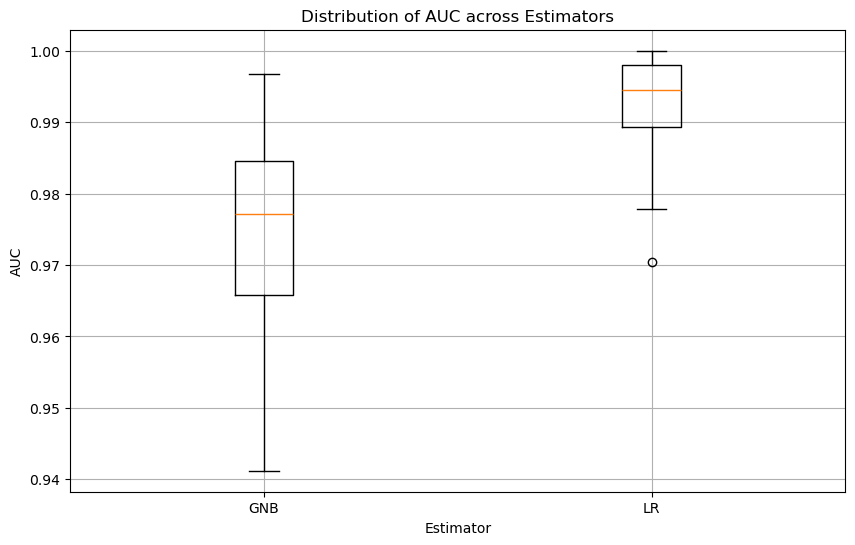

In [8]:
# Group AUC scores by estimator
grouped = df_results.groupby('estimator')['AUC'].apply(list)

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped.values, tick_labels=grouped.index)

plt.title('Distribution of AUC across Estimators')
plt.xlabel('Estimator')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

In [9]:
median_df = df_results.drop(columns=["repetition", "outer_fold"]).groupby("estimator").median()
median_df

,MCC,AUC,BA,F1,F2,Recall,Precision
estimator,,,,,,,
GNB,0.832237,0.977179,0.909840,0.893314,0.875338,0.868421,0.915476
LR,0.927621,0.994523,0.961032,0.953811,0.947368,0.947368,0.972222
